In [1]:
import matplotlib
matplotlib.use('Agg')

% matplotlib inline

# homebrewed modules
from metro import multiplex as mx
from metro import io            # for reading multiplex
from metro import utility       # for manipulating multiplex
from metro import analysis      # analytical functions
from metro import viz           # for bubble_plot()
from metro import assignment    # for reading and manipulating OD data
from metro import ita

# other modules
import warnings                 # suppress ipython warnings
import networkx as nx           # assigning attributes to multiplex
import random                   # randomly sample node subsets
import matplotlib.pyplot as plt # convenience for plotting

from matplotlib import pylab    # for colormap manipulation
import numpy as np              # math functions
import igraph
import pandas as pd
import matplotlib.cm as cm
import copy
from copy import deepcopy
pylab.rcParams['savefig.dpi'] = 300 # should be ~300 for final figs
import Image

import seaborn as sns
sns.set_context("paper")

:0: FutureWarning: IPython widgets are experimental and may change in the future.


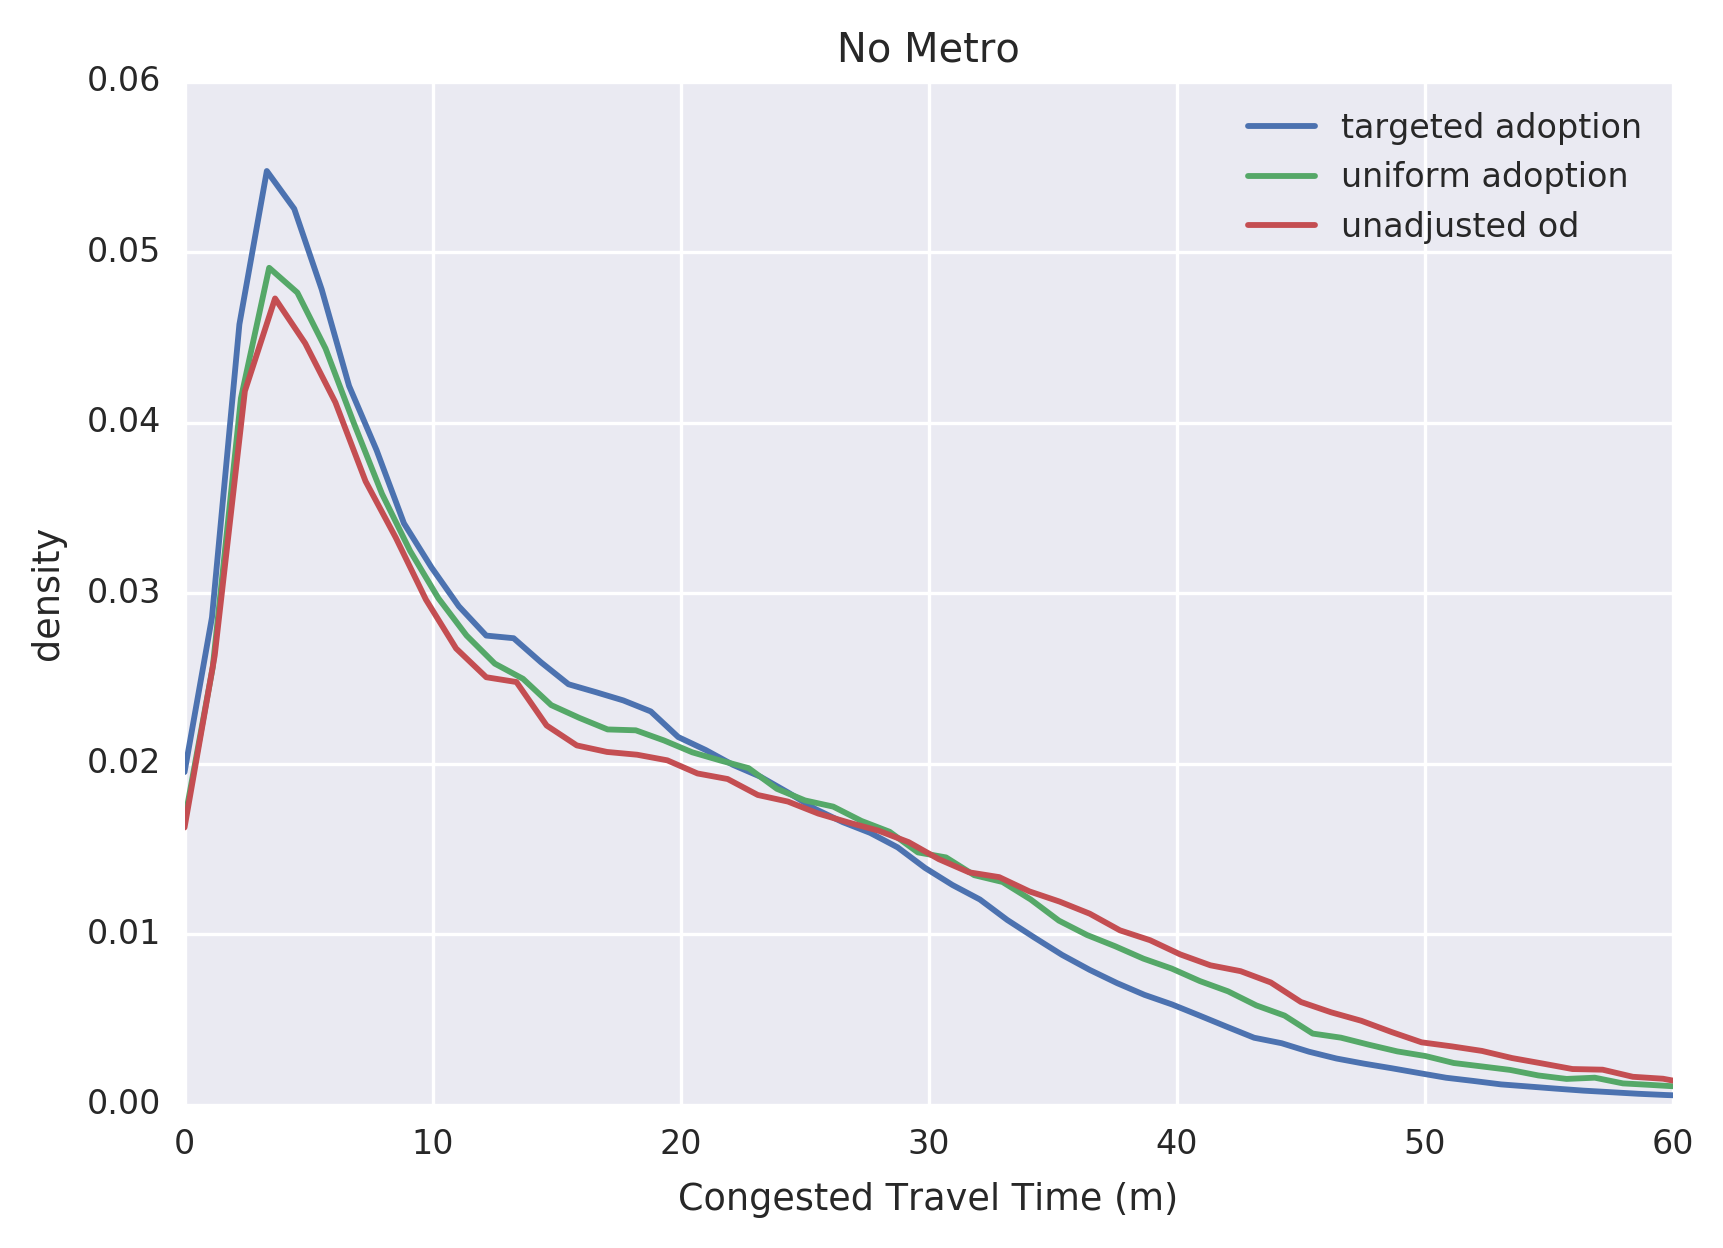

In [2]:
beta = 100.0

df = pd.read_csv('3_throughput/targeted_' + str(beta) + '.csv')
dg = pd.read_csv('3_throughput/uniform_' + str(beta) + '.csv')
dh = pd.read_csv('3_throughput/route_info_' + str(beta) + '.csv')

fig = plt.figure()
ax1 = fig.add_subplot(111)
viz.weighted_hist(ax = ax1, 
                      measure = df.congested_time_m, 
                      weights = df.flow, 
                      label = 'targeted adoption',  
                      standardized = False,
                      n = 100)

viz.weighted_hist(ax = ax1, 
                      measure = dg.congested_time_m, 
                      weights = dg.flow, 
                      label = 'uniform adoption',  
                      standardized = False,
                      n = 100)

viz.weighted_hist(ax = ax1, 
                      measure = dh.congested_time_m, 
                      weights = dh.flow, 
                      label = 'unadjusted od',  
                      standardized = False,
                      n = 100)

# viz.weighted_hist(ax = ax1, 
#                       measure = dg.congested_time_m - dg.free_flow_time_m, 
#                       weights = dg.flow, 
#                       label = 'uniform -- congested only',  
#                       standardized = False,
#                       n = 100)

# viz.weighted_hist(ax = ax1, 
#                       measure = df.congested_time_m - df.free_flow_time_m, 
#                       weights = df.flow, 
#                       label = 'targeted -- congested only',  
#                       standardized = False,
#                       n = 100)

if beta == 100:
    title = r'No Metro'
else:
    title = r'$\beta = $' + str(beta)

ax1.legend()
ax1.set(xlim = (0, 60), 
        xlabel = 'Congested Travel Time (m)', 
        ylabel = 'density', 
        title = title)

plt.savefig('4_figs/scenario_' +str(beta) + '.png')


In [3]:
betas = pd.read_csv('plot_betas.csv')['beta']    

In [4]:
dg = pd.DataFrame()

for scenario in ['unadjusted', 'uniform', 'targeted']:
    if scenario == 'unadjusted':
        prefix = '3_throughput/route_info_'
    else:
        prefix = '3_throughput/' + scenario + '_' 
    
    for beta in betas: 
        suffix = str(beta) + '.csv'

        df = pd.read_csv(prefix + suffix)

        total = np.average(df.congested_time_m, weights=df.flow)
        in_congestion = total - np.average(df.free_flow_time_m, weights = df.flow)

        row = {'beta' : beta, 'scenario' : scenario, 'total': total, 'in_congestion' : in_congestion}
        dg = dg.append(row, ignore_index=True)

In [5]:
dg['free'] = dg.total - dg.in_congestion
dg['cong_name'] = dg.scenario + ' (lost to congestion)' 
dg['free_name'] = dg.scenario + ' (in free flow)'
dg['beta_name_part'] = r'$\beta = $'
dg['beta_name'] = dg.beta_name_part + dg.beta.astype('string')
dg.ix[dg.beta_name == r'$\beta = $' + str(100.0), 'beta_name'] = 'No Metro'

In [6]:
dg.head()

,beta,in_congestion,scenario,total,free,cong_name,free_name,beta_name_part,beta_name
0,100.00,3.949349,unadjusted,19.362244,15.412894,unadjusted (lost to congestion),unadjusted (in free flow),$\beta = $,No Metro
1,1.00,2.317357,unadjusted,17.364839,15.047483,unadjusted (lost to congestion),unadjusted (in free flow),$\beta = $,$\beta = $1.0
2,0.80,1.506161,unadjusted,16.075453,14.569292,unadjusted (lost to congestion),unadjusted (in free flow),$\beta = $,$\beta = $0.8
3,0.50,1.252225,unadjusted,14.394451,13.142226,unadjusted (lost to congestion),unadjusted (in free flow),$\beta = $,$\beta = $0.5
4,0.01,1.615556,unadjusted,10.807302,9.191746,unadjusted (lost to congestion),unadjusted (in free flow),$\beta = $,$\beta = $0.01


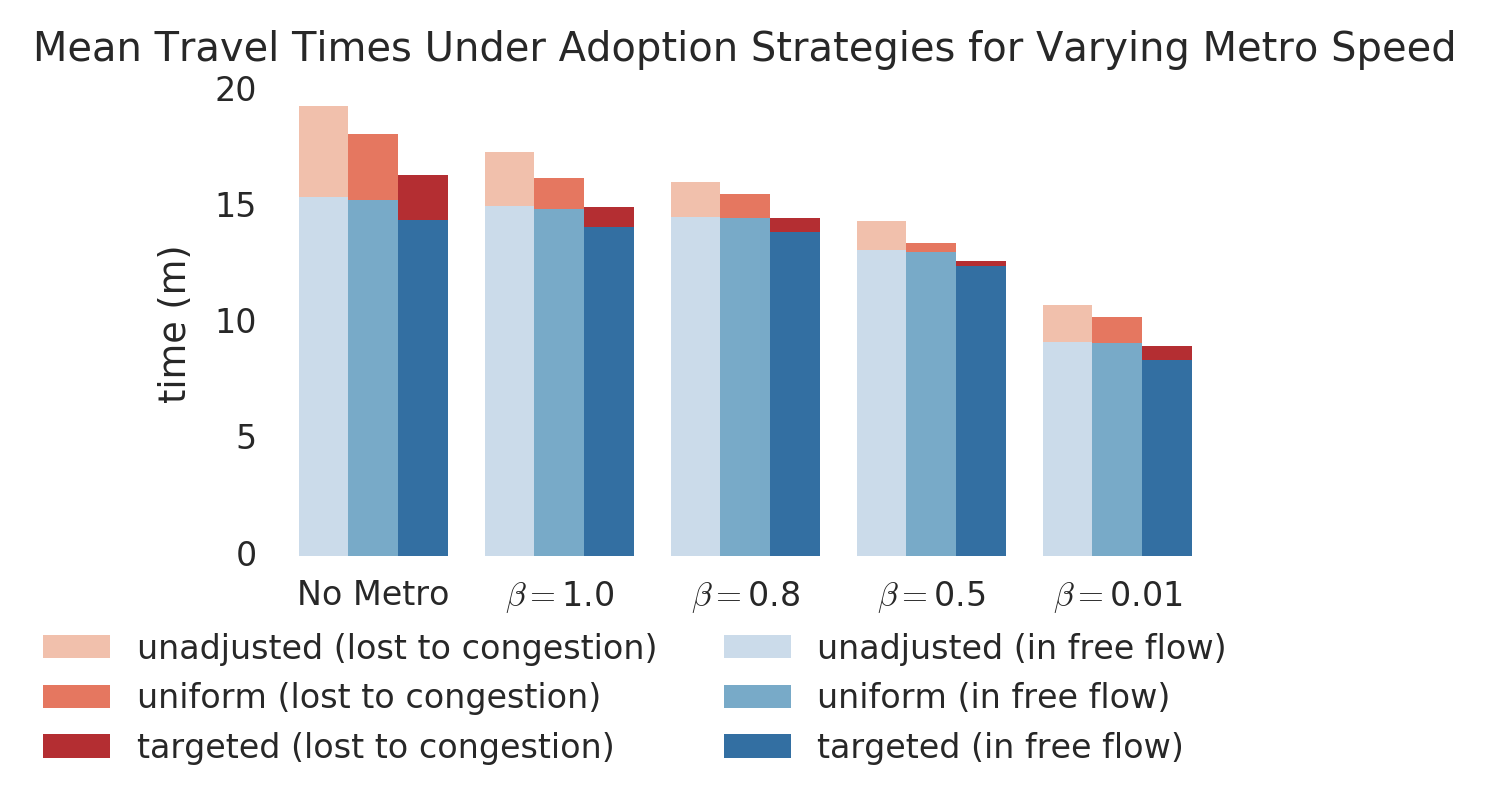

In [7]:
sns.set_style("white")
fig = plt.figure(figsize = (4, 2))
ax = fig.add_subplot(111)

sns.barplot(x = dg.beta_name, y = dg.total, hue = dg.cong_name, palette = 'Reds', ax = ax, linewidth=0)
sns.barplot(x = dg.beta_name, y = dg.free, hue = dg.free_name, palette = 'Blues', ax = ax, linewidth=0)

ax.set(xlabel = '', ylabel = 'time (m)')
ax.set_title('Mean Travel Times Under Adoption Strategies for Varying Metro Speed', y=1.02)

l = plt.legend(title = None, ncol = 2, bbox_to_anchor=(1.05, -.1))
# plt.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
sns.despine(left = True, bottom = True)

plt.savefig('4_figs/strategy_barplot.tif', bbox_inches = 'tight')



In [8]:
dg

,beta,in_congestion,scenario,total,free,cong_name,free_name,beta_name_part,beta_name
0,100.00,3.949349,unadjusted,19.362244,15.412894,unadjusted (lost to congestion),unadjusted (in free flow),$\beta = $,No Metro
1,1.00,2.317357,unadjusted,17.364839,15.047483,unadjusted (lost to congestion),unadjusted (in free flow),$\beta = $,$\beta = $1.0
2,0.80,1.506161,unadjusted,16.075453,14.569292,unadjusted (lost to congestion),unadjusted (in free flow),$\beta = $,$\beta = $0.8
3,0.50,1.252225,unadjusted,14.394451,13.142226,unadjusted (lost to congestion),unadjusted (in free flow),$\beta = $,$\beta = $0.5
4,0.01,1.615556,unadjusted,10.807302,9.191746,unadjusted (lost to congestion),unadjusted (in free flow),$\beta = $,$\beta = $0.01
5,100.00,2.858173,uniform,18.156308,15.298135,uniform (lost to congestion),uniform (in free flow),$\beta = $,No Metro
6,1.00,1.304344,uniform,16.231767,14.927423,uniform (lost to congestion),uniform (in free flow),$\beta = $,$\beta = $1.0
7,0.80,1.038944,uniform,15.571556,14.532612,uniform (lost to congestion),uniform (in free flow),$\beta = $,$\beta = $0.8
8,0.50,0.384523,uniform,13.463534,13.079011,uniform (lost to congestion),uniform (in free flow),$\beta = $,$\beta = $0.5
9,0.01,1.125977,uniform,10.268485,9.142508,uniform (lost to congestion),uniform (in free flow),$\beta = $,$\beta = $0.01
